In [2]:
from pynori.utils import depth_corrector, get_layers, find_layer_coordinates, find_closest_layer_index, find_values_within_radius_2d, get_plotting_data, find_elements_within_ellipsoid
from pynori.plotter import scatter
from pyplume.plotting.matplotlib_shell import subplots, dhi_colors
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mikeio
import os

In [3]:
### pr1 test
model_fname = r"\\USDEN1-STOR.DHI.DK\Projects\41806287\Models\Midwater\05_runs\rev3\midwater_plume_pr1test.m3fm - Result Files\MT_3D_Items\Total SSC.dfsu"
depth_correction = -1200
test_name = "pr1"

### pr2 test
#model_fname = r"\\USDEN1-STOR.DHI.DK\Projects\41806287\Models\Midwater\05_runs\rev3\midwater_plume_pr2test.m3fm - Result Files\MT_3D_items\Total_SSC.dfsu"
#depth_correction = -1225
#test_name = "pr2"

### str test
#model_fname = r"\\USDEN1-STOR.DHI.DK\Projects\41806287\Models\Midwater\05_runs\rev3\midwater_plume_str_test.m3fm - Result Files\MT_3D_items\Total SSC.dfsu"
#depth_correction = -1225
#test_name = "str"

### ROV Near Field
ROV = pd.read_csv(r"\\USDEN1-STOR.DHI.DK\Projects\41806287\41806287 NORI-D Data\Workflow Execution\ROV CTD Calibration\observations\ROV\near field\01_near_field_ROV_CTD.csv", index_col=0, parse_dates=True)
ROV_loc = "Near Field"
### ROV Far Field
#ROV = pd.read_csv(r"\\USDEN1-STOR.DHI.DK\Projects\41806287\41806287 NORI-D Data\Workflow Execution\ROV CTD Calibration\observations\ROV\far field\01_far_field_ROV_CTD.csv", index_col=0, parse_dates=True)
#ROV_loc = "Far Field"


mask = (ROV["AREA"] == "MIDWATER")
ROV = ROV[mask]
radii = [25, 50, 75, 100]

change_sign = True
model_unit_conversion = 1000


#####################################################################################################################################

In [4]:
dfsu = mikeio.read(model_fname)[0]

element_coordinates = dfsu.geometry.element_coordinates.copy()
element_coordinates = depth_corrector(element_coordinates, depth_correction, change_sign)
layers = get_layers(element_coordinates)
values = dfsu.values.copy()
times = dfsu.time.copy()
if test_name == "str":
    times = times + pd.Timedelta(seconds=1)
print("Model loaded!")

100%|██████████| 1891/1891 [01:06<00:00, 28.24it/s]


Model loaded!


ROV loaded!
Outputs calculated for radius 25!
Outputs calculated for radius 50!
Outputs calculated for radius 75!
Outputs calculated for radius 100!


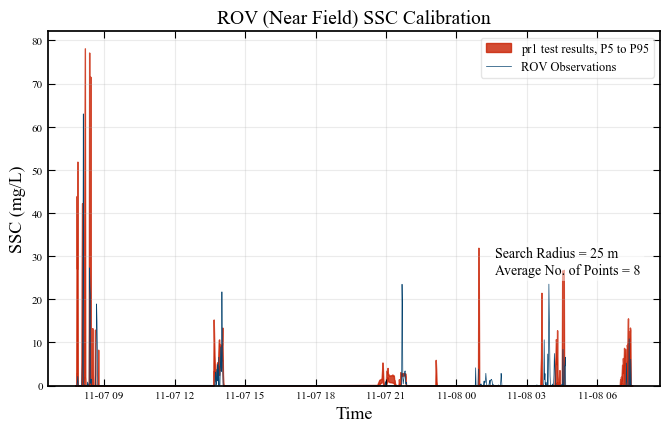

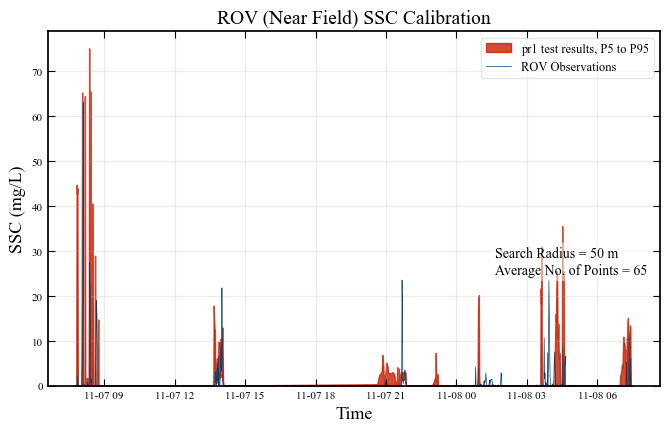

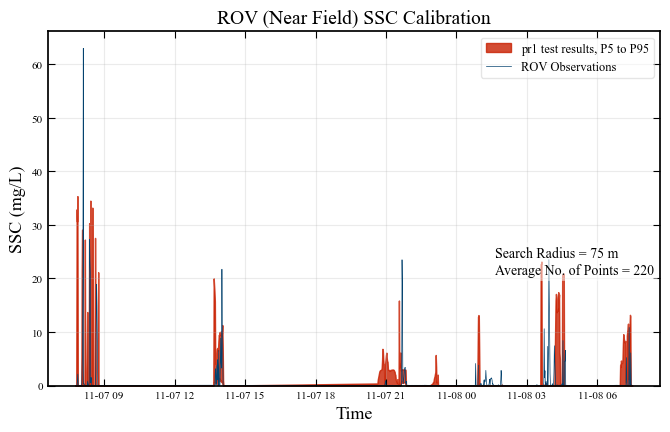

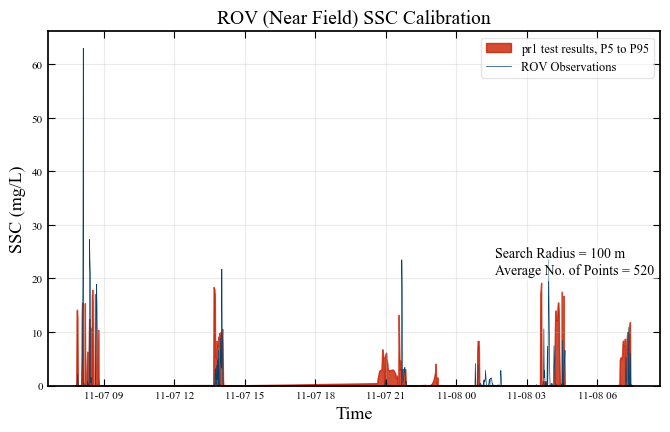

In [31]:
ROV_time = ROV.index.copy()
time_intersection = times.intersection(ROV_time)
ROV = ROV.loc[time_intersection]
ROV_time = ROV.index.copy()

ROV_x = ROV["ROV Easting"].to_numpy().copy()
ROV_y = ROV["ROV Northing"].to_numpy().copy()
ROV_z = ROV["ROV Depth"].to_numpy().copy()
ROV_coordinates = np.vstack((ROV_x, ROV_y, ROV_z)).T
ROV_values = ROV["SSC (mg/L)"].to_numpy().copy()
print("ROV loaded!")
for radius in radii:
    outputs = {"Time": [], "Min": [], "P1": [], "P5": [], "P10": [], "Mean": [], "P90": [], "P95": [], "P99": [], "Max": []}
    n_points = []
    ROV_values_final = []
    ROV_time_final = []
    for i, time in enumerate(time_intersection):
        time_index = np.where(times == time)[0][0]
        ROV_time_index = np.where(ROV_time == time)[0][0]
        ROV_point = ROV_coordinates[ROV_time_index, :]
        nearest_elements = find_elements_within_ellipsoid(element_coordinates, ROV_point, horizontal_radius=radius, vertical_to_horizontal_resolution=1/20)
        output_values = values[time_index, nearest_elements]
        if len(output_values) == 0:
            continue
        ROV_values_final.append(ROV_values[ROV_time_index])
        ROV_time_final.append(time)
        outputs["Time"].append(time)
        outputs["Min"].append(np.min(output_values))
        outputs["P1"].append(np.percentile(output_values, 1))
        outputs["P5"].append(np.percentile(output_values, 5))
        outputs["P10"].append(np.percentile(output_values, 10))
        outputs["Mean"].append(np.mean(output_values))
        outputs["P90"].append(np.percentile(output_values, 90))
        outputs["P95"].append(np.percentile(output_values, 95))
        outputs["P99"].append(np.percentile(output_values, 99))
        outputs["Max"].append(np.max(output_values))
        
        n_points.append(len(output_values))
    print(f"Outputs calculated for radius {radius}!")
    outputs = pd.DataFrame(outputs)
    outputs.set_index("Time", inplace=True)
    outputs = outputs * model_unit_conversion

    fig, ax = subplots(figheight=5, figwidth=7)
    ax.fill_between(outputs.index, outputs["P5"], outputs["P95"], color=dhi_colors.red1, alpha=0.8, label=f"{test_name} test results, P5 to P95")
    ax.plot(ROV_time_final, ROV_values_final, label="ROV Observations", color=dhi_colors.blue1, linewidth=0.5)
    metadata = f"Search Radius = {radius} m\nAverage No. of Points = {int(np.mean(n_points))}"
    props = dict(boxstyle='round', facecolor='white', edgecolor="none", alpha=0.5)
    ax.text(0.71, 0.75, metadata, transform=ax.transAxes, fontsize=10, verticalalignment='center', horizontalalignment="left", bbox=props)
    ax.legend(loc="upper right")
    ax.set_xlabel("Time")
    ax.set_ylabel("SSC (mg/L)")
    ax.set_title(f"ROV ({ROV_loc}) SSC Calibration")
    ax.set_ylim(bottom=0)
    fig.savefig(f"ROV_{ROV_loc}_{test_name}_SSC_Calibration_Radius_{radius}.png", dpi=600)

(0.0, 66.1147592217899)

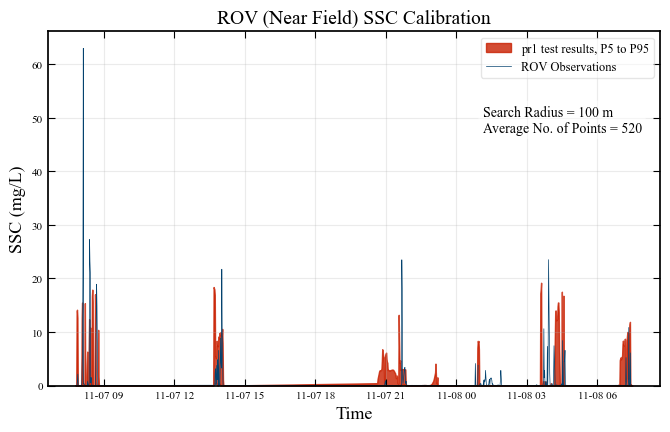

In [33]:
fig, ax = subplots(figheight=5, figwidth=7)
ax.fill_between(outputs.index, outputs["P5"], outputs["P95"], color=dhi_colors.red1, alpha=0.8, label=f"{test_name} test results, P5 to P95")
ax.plot(ROV_time_final, ROV_values_final, label="ROV Observations", color=dhi_colors.blue1, linewidth=0.5)
metadata = f"Search Radius = {radius} m\nAverage No. of Points = {int(np.mean(n_points))}"
props = dict(boxstyle='round', facecolor='white', edgecolor="none", alpha=0.5)
ax.text(0.71, 0.75, metadata, transform=ax.transAxes, fontsize=10, verticalalignment='center', horizontalalignment="left", bbox=props)
ax.legend(loc="upper right")
ax.set_xlabel("Time")
ax.set_ylabel("SSC (mg/L)")
ax.set_title(f"ROV ({ROV_loc}) SSC Calibration")
ax.set_ylim(bottom=0)